In [32]:
from config import DATABASE_URI

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import io
import psycopg2

In [21]:
def get_images_from_db():
    #We connect to the local DB
    conn = psycopg2.connect(DATABASE_URI)
    
    cursor = conn.cursor()
    cursor.execute("SELECT fruit_name, image FROM fruits")
    
    #Stract all images binary information and also the fruit name into rows 
    rows = cursor.fetchall()
    images, labels = [], []
    
    #loop throu each row and append image information in a np array into the list images
    for row in rows:
        
        fruit_name, binary_data = row
        # getting the image and resize to 128x128 and making sure is RGB for the model
        image = Image.open(io.BytesIO(binary_data)).convert('RGB')
        image = image.resize((128, 128))
        
        #append the image and the label into images and labels lists 
        images.append(np.array(image))
        labels.append(fruit_name)
    cursor.close()
    conn.close()
    return np.array(images), np.array(labels)

images, labels = get_images_from_db()
print(f'Retrieved {len(images)} images from the database.')

Retrieved 9678 images from the database.


In [22]:
# Normalize the images
images = images / 255.0

# Encode labels as integers
label_encoder = LabelEncoder()

labels = label_encoder.fit_transform(labels)
#split the images into 80% training and 20% test 
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# FIRST MODEL TESTED

In [23]:
# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\Javier Alarcon\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,973 (12.47 MB)

 Trainable params: 3,267,973 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.3969 - loss: 1.4536 - val_accuracy: 0.5165 - val_loss: 1.1684
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.5454 - loss: 1.0795 - val_accuracy: 0.5733 - val_loss: 1.0336
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.6046 - loss: 0.9706 - val_accuracy: 0.5956 - val_loss: 0.9854
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.6543 - loss: 0.8651 - val_accuracy: 0.5806 - val_loss: 1.0320
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.7268 - loss: 0.7017 - val_accuracy: 0.6028 - val_loss: 1.0527
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.8107 - loss: 0.5076 - val_accuracy: 0.6209 - val_loss: 1.1206
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.8981 - loss: 0.3041 - val_accuracy: 0.5992 - val_loss: 1.4224
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.9349 - loss: 0

In [25]:
# Save the model
model.save('NeuralNetwork_train_model/fruit_classifier_model.h5')

In [26]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

61/61 - 2s - 29ms/step - accuracy: 0.6126 - loss: 2.2813
Test accuracy: 0.6126033067703247


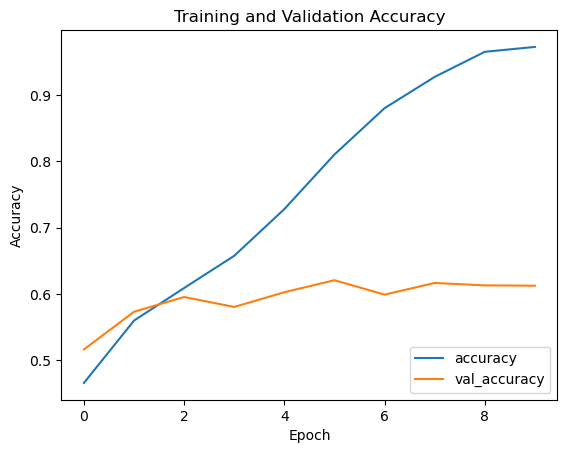

In [28]:
# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('Accuracy_Epoch_Graph_images/model_1')
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


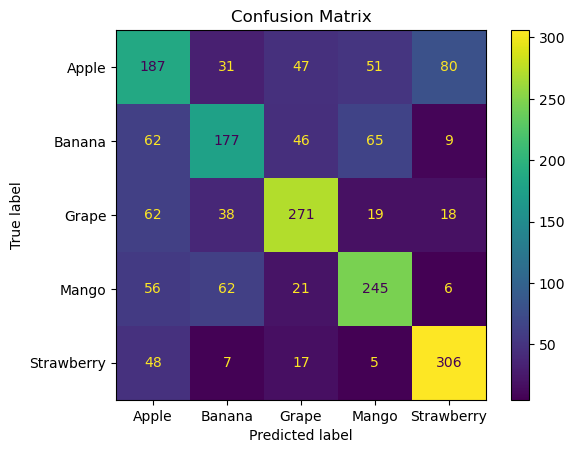

In [30]:
# Plot confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
cmd.plot()
plt.title('Confusion Matrix')
plt.savefig('Confusion_matrix_images/model_1')
plt.show()

In [33]:
# Save the label encoder
import pickle

with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [34]:
#Printing the classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       Apple       0.45      0.47      0.46       396
      Banana       0.56      0.49      0.53       359
       Grape       0.67      0.66      0.67       408
       Mango       0.64      0.63      0.63       390
  Strawberry       0.73      0.80      0.76       383

    accuracy                           0.61      1936
   macro avg       0.61      0.61      0.61      1936
weighted avg       0.61      0.61      0.61      1936



# SECOND MODEL TESTED

In [35]:

# This model has more deep layers to the neural network
model_2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_2.summary()


c:\Users\Javier Alarcon\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 831,429 (3.17 MB)

 Trainable params: 831,429 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Train the model
history_2 = model_2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.4032 - loss: 1.3394 - val_accuracy: 0.5790 - val_loss: 1.0058
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 129ms/step - accuracy: 0.5424 - loss: 1.0509 - val_accuracy: 0.6142 - val_loss: 0.9520
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 130ms/step - accuracy: 0.6305 - loss: 0.9375 - val_accuracy: 0.6265 - val_loss: 0.9215
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - accuracy: 0.6530 - loss: 0.8620 - val_accuracy: 0.6400 - val_loss: 0.9062
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.6834 - loss: 0.7905 - val_accuracy: 0.6942 - val_loss: 0.8290
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 129ms/step - accuracy: 0.7453 - loss: 0.6540 - val_accuracy: 0.6720 - val_loss: 0.8202
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.7796 - loss: 0.5725 - val_accuracy: 0.6942 - val_loss: 0.8301
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.8297 - loss: 0

In [37]:
# Save the model
model_2.save('NeuralNetwork_train_model/fruit_classifier_model_2.h5')

In [38]:
# Evaluate the model
test_loss, test_acc = model_2.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

61/61 - 2s - 34ms/step - accuracy: 0.6725 - loss: 1.2103
Test accuracy: 0.672520637512207


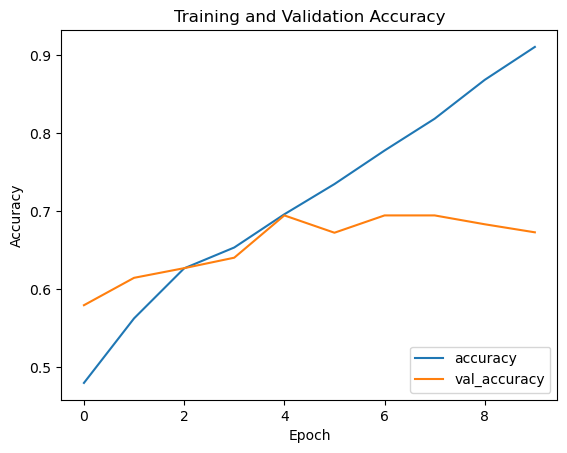

In [39]:
# Plot accuracy over epochs
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.plot(history_2.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('Accuracy_Epoch_Graph_images/model_2')
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


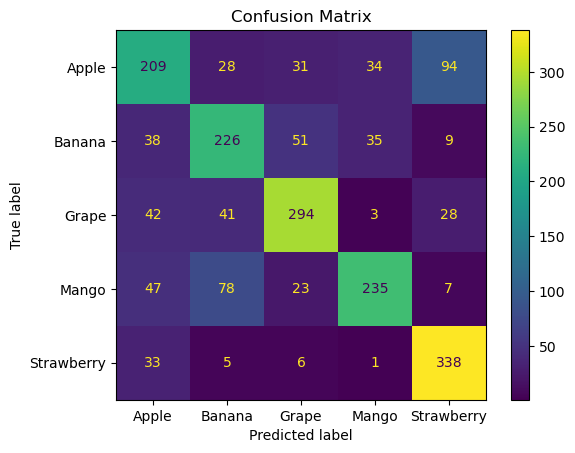

In [40]:
# Plot confusion matrix
y_pred_2 = model_2.predict(X_test)
y_pred_classes_2 = np.argmax(y_pred_2, axis=1)
cm = confusion_matrix(y_test, y_pred_classes_2)
cmd = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
cmd.plot()
plt.title('Confusion Matrix')
plt.savefig('Confusion_matrix_images/model_2')
plt.show()

In [48]:
print(classification_report(y_test, y_pred_classes_2, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       Apple       0.57      0.53      0.55       396
      Banana       0.60      0.63      0.61       359
       Grape       0.73      0.72      0.72       408
       Mango       0.76      0.60      0.67       390
  Strawberry       0.71      0.88      0.79       383

    accuracy                           0.67      1936
   macro avg       0.67      0.67      0.67      1936
weighted avg       0.67      0.67      0.67      1936



# THIRD MODEL TESTED 

In [41]:
# Build and compile the model
# this is a pretrain model which contains a model that could perform better than hand made more basic models
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)
model_3 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [43]:
# Train the model
history_3 = model_3.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - accuracy: 0.7229 - loss: 0.7439 - val_accuracy: 0.8502 - val_loss: 0.4247
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.8911 - loss: 0.3201 - val_accuracy: 0.8388 - val_loss: 0.4493
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9188 - loss: 0.2375 - val_accuracy: 0.8574 - val_loss: 0.3885
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9483 - loss: 0.1646 - val_accuracy: 0.8528 - val_loss: 0.4220
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9644 - loss: 0.1171 - val_accuracy: 0.8652 - val_loss: 0.4253
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9806 - loss: 0.0742 - val_accuracy: 0.8647 - val_loss: 0.4365
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9912 - loss: 0.0485 - val_accuracy: 0.8549 - val_loss: 0.4600
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9974 - loss: 0.0301 - 

In [44]:
# Evaluate the model
test_loss, test_acc = model_3.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

61/61 - 4s - 71ms/step - accuracy: 0.8626 - loss: 0.5219
Test accuracy: 0.8626033067703247


In [45]:
# Save the model
model.save('NeuralNetwork_train_model/fruit_classifier_mobilenetv2.h5')

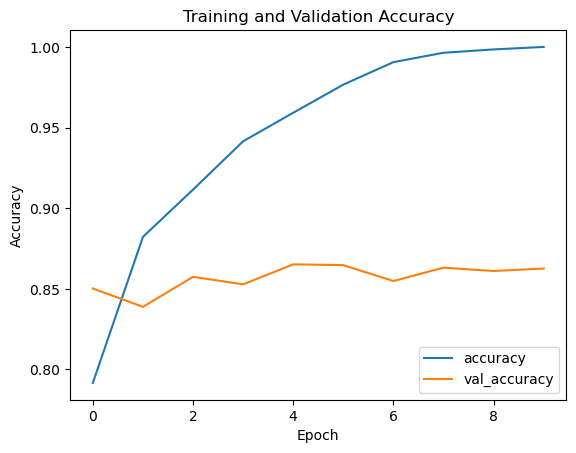

In [46]:
# Plot accuracy over epochs
plt.plot(history_3.history['accuracy'], label='accuracy')
plt.plot(history_3.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('Accuracy_Epoch_Graph_images/model_3')
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step


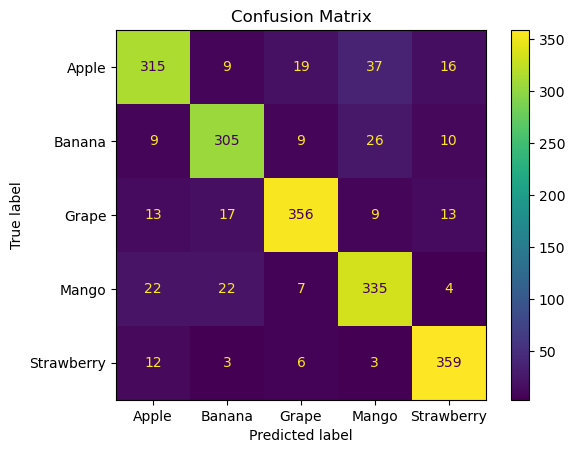

In [47]:
# Plot confusion matrix
y_pred_3 = model_3.predict(X_test)
y_pred_classes_3 = np.argmax(y_pred_3, axis=1)
cm = confusion_matrix(y_test, y_pred_classes_3)
cmd = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
cmd.plot()
plt.title('Confusion Matrix')
plt.savefig('Confusion_matrix_images/model_3')
plt.show()

In [49]:
print(classification_report(y_test, y_pred_classes_3, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       Apple       0.85      0.80      0.82       396
      Banana       0.86      0.85      0.85       359
       Grape       0.90      0.87      0.88       408
       Mango       0.82      0.86      0.84       390
  Strawberry       0.89      0.94      0.91       383

    accuracy                           0.86      1936
   macro avg       0.86      0.86      0.86      1936
weighted avg       0.86      0.86      0.86      1936

